# Infinite
Comparing various implementations of the window calculation.

In [1]:
from pathlib import Path
from functools import partial
#import os
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.' # NOTE: jax preallocates GPU (default 75%)

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jaxpower import (ParticleField, compute_mesh_power, compute_mean_mesh_power, compute_mesh_window,
compute_normalization, generate_anisotropic_gaussian_mesh, BinnedStatistic, MeshAttrs, utils)
from jaxwindow import WindowMatrixEstimator

plots_dir = Path('_plots')

In [2]:
# To highlight the effect of the window convolution,
# we generate a power spectrum with high frequency BAO

mattrs = MeshAttrs(boxsize=2000., meshsize=128)

from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu_nowiggle')
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
edgesin = jnp.linspace(0., mattrs.knyq.min(), 400)
kin = (edgesin[:-1] + edgesin[1:]) / 2.
pkin = pk(kin) * (1. + 0.2 * np.sin(kin / 0.006))
ells = (0, 2, 4)

f, b = 0.8, 1.5
pkb = b**2 * pkin
beta = f / b
poles = [(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pkb,
         0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pkb,
          8. / 35 * beta ** 2 * pkb]
poles = jnp.array(poles)
theory = BinnedStatistic(x=(kin,) * len(ells), value=poles, projs=ells)
edges = {'step': 0.005}
los = 'x'

# Selection function
def gaussian_survey(mattrs, size=int(1e8), seed=random.key(42), scale=0.2, paint=False):
    boxsize, meshsize, boxcenter = mattrs.boxsize, mattrs.meshsize, mattrs.boxcenter
    # Generate Gaussian-distributed positions
    positions = scale * random.normal(seed, shape=(size, 3))
    bscale = 2. * scale  # cut at 2 sigmas
    mask = jnp.all((positions > -bscale) & (positions < bscale), axis=-1)
    positions = positions * boxsize + boxcenter
    toret = ParticleField(positions, weights=1. * mask, boxcenter=boxcenter, boxsize=boxsize, meshsize=meshsize)
    if paint: toret = toret.paint(resampler='cic', interlacing=1, compensate=False)
    return toret

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20241221-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [3]:
selection = gaussian_survey(mattrs=mattrs, paint=True)
norm = compute_normalization(selection, selection)

In [4]:
los = 'x'
mean = compute_mean_mesh_power(selection, theory=theory, ells=ells, edges=edges, los=los).clone(norm=norm)
kw = dict(edgesin=edgesin, ellsin=ells, ells=ells, edges=edges, los=los, norm=norm)
wmatrix_infinite = compute_mesh_window(selection, **kw, flags=('infinite',))

In [5]:
wmatrix_smooth = compute_mesh_window(selection, **kw, flags=('smooth',))

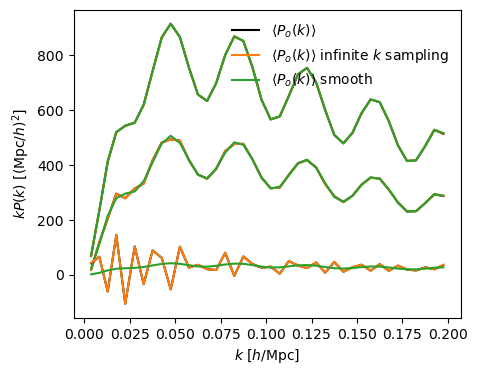

In [6]:
infinite = wmatrix_infinite.dot(theory.view(), zpt=False, return_type=None)
smooth = wmatrix_smooth.dot(theory.view(), zpt=False, return_type=None)

ax = plt.gca()
colors = ['k', 'C1', 'C2']
labels = [r'$\langle P_o(k) \rangle$',
          r'$\langle P_o(k) \rangle$ infinite $k$ sampling',
          r'$\langle P_o(k) \rangle$ smooth']
for color, label in zip(colors, labels):
    ax.plot([], [], color=color, linestyle='-', label=label)
for ill, ell in enumerate(ells):
    k = mean.x(projs=ell)
    ax.plot(k, k * mean.view(projs=ell), color=colors[0])
    ax.plot(k, k * infinite.view(projs=ell), color=colors[1])
    ax.plot(k, k * smooth.view(projs=ell), color=colors[2])
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

Black (box) is behind orange curve. Monopoles are on top of each others.